<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/Pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

In [6]:
# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho_sea = 1100  # density of sea water in kg/m^3
water_depth = 1000  # water depth hw = 1 km in meters

# Layer properties (example values)
layer_thicknesses = np.array([1000, 2000, 3000])  # in meters
rock_densities = np.array([2700, 2700, 2700])  # in kg/m^3
porosities = np.array([0.0, 0.0, 0.0])

# Calculate lithostatic pressure at depth h
def lithostatic_pressure_onshore(h):
    layer_depths = np.cumsum(layer_thicknesses)
    pressure = 0
    for thickness, density, porosity in zip(layer_thicknesses, rock_densities, porosities):
        if h > 0:
            effective_thickness = min(thickness, h)
            pressure += g * density * (1 - porosity) * effective_thickness
            h -= thickness
        else:
            break
    return pressure / 1e6  # Convert Pa to MPa

def lithostatic_pressure_offshore(h):
    if h <= water_depth:
        return g * rho_sea * h / 1e6  # Hydrostatic pressure from water
    else:
        pressure = g * rho_sea * water_depth  # Hydrostatic pressure from water column
        h -= water_depth
        return (pressure + lithostatic_pressure_onshore(h) * 1e6) / 1e6  # Add lithostatic pressure from sediments

# Example usage
depth = 4000  # depth in meters
print("Onshore Lithostatic Pressure at 1500 m:", lithostatic_pressure_onshore(depth), "MPa")
print("Offshore Lithostatic Pressure at 1500 m:", lithostatic_pressure_offshore(depth), "MPa")

Onshore Lithostatic Pressure at 1500 m: 105.948 MPa
Offshore Lithostatic Pressure at 1500 m: 90.252 MPa


In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

In [43]:
# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho_sea = 1100  # density of sea water in kg/m^3
rho_w = 1040  # density of pore water in kg/m^3
rho_shale = 2700  # density of shale in kg/m^3
rho_sandstone = 2720  # density of sandstone in kg/m^3
water_depth = 1000  # water depth hw = 1 km in meters

In [7]:
def hydrostatic_pressures(depths):

    GRAVITY = 9.81
    DENSITY_SEA_WATER = 1100  # Density of sea water (kg/m^3)

    """Calculate hydrostatic pressures for an array of depths."""

    pressures = [quad(lambda z: DENSITY_SEA_WATER * GRAVITY, 0, depth)[0] / 1e6 for depth in depths]  # Convert Pa to MPa
    return pressures

In [15]:
def lithostatic_pressures(layer_thicknesses, rock_densities, porosities):

    from scipy.integrate import quad
    GRAVITY = 9.81  # Acceleration due to gravity (m/s^2)
    DENSITY_SEA_WATER = 1100  # Density of sea water (kg/m^3)

    """
    Calculate cumulative lithostatic pressures for each layer.

    Parameters:
    - layer_thicknesses: List or array of thicknesses of each layer (m)
    - rock_densities: List or array of densities of each rock layer (kg/m^3)
    - porosities: List or array of porosity values for each layer (fraction)

    Returns:
    - List of cumulative pressures (MPa) for each layer
    """
    layer_depths = np.cumsum(layer_thicknesses)
    print("Layer Depths:", layer_depths, "Number of Layers:", len(layer_depths))

    def lithostatic_pressure_calculation(rho_rock, porosity, upper_bound, lower_bound):
        rho_effective = (1 - porosity) * rho_rock + porosity * DENSITY_SEA_WATER
        print(f"Effective Density: {rho_effective}, Porosity: {porosity}, Depth Range: {lower_bound}-{upper_bound} m")
        return quad(lambda z: rho_effective * GRAVITY, lower_bound, upper_bound)[0] / 1e6

    previous_layer_depth = 0
    cumulative_pressure = 0
    pressures = []

    for layer_depth, rho_rock, porosity in zip(layer_depths, rock_densities, porosities):
        pressure = lithostatic_pressure_calculation(rho_rock, porosity, layer_depth, previous_layer_depth)
        cumulative_pressure += pressure
        pressures.append(cumulative_pressure)
        previous_layer_depth = layer_depth

    return pressures

In [ ]:
# Example usage:
# Layer properties
layer_thicknesses = np.array([-1000, 1000, 1000, 1000, 1000, 1000])  # thickness of each layer in meters
rock_densities = np.array([2700, 2700, 2700, 2700, 2700, 2700])  # density of each rock layer in kg/m^3
porosities = np.array([0., 0., 0., 0., 0., 0.])  # porosity of each layer

pressures_lit = lithostatic_pressures(layer_thicknesses, rock_densities, porosities)
layer_depths = np.cumsum(layer_thicknesses/1000)
layer_depths = np.insert(layer_depths, 0, 0)
pressures_lit = np.insert(pressures_lit, 0, 0)

print("Cumulative Pressures Lith:", pressures_lit )


Layer Depths: [-1000     0  1000  2000  3000  4000] Number of Layers: 6
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0--1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: -1000-0 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0-1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 1000-2000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 2000-3000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 3000-4000 m
Cumulative Pressures Lith: [  0.    -26.487   0.     26.487  52.974  79.461 105.948]


In [ ]:
depths = np.linspace(0, 6000, 6)  # 0 to 5 km
pressures_hydrostatic = hydrostatic_pressures(depths)
depths = depths/1000
print("Hydrostatic pressures:", pressures_hydrostatic)

Hydrostatic pressures: [0.0, 12.9492, 25.8984, 38.8476, 51.7968, 64.746]


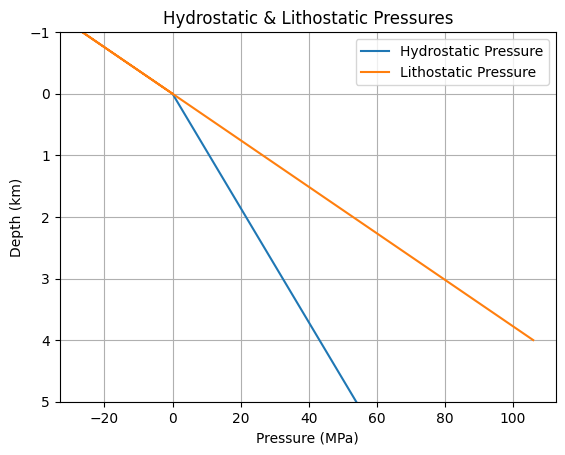

In [ ]:
# Offshore plot
ax1 = plt.subplot(1, 1, 1)

plt.plot(pressures_hydrostatic, depths, label='Hydrostatic Pressure')
plt.plot(pressures_lit, layer_depths, label='Lithostatic Pressure')
plt.title('Hydrostatic & Lithostatic Pressures')
plt.ylabel('Depth (km)')
plt.xlabel('Pressure (MPa)')
# plt.xlim(0, 60)
plt.ylim(-1, 5)
ax1.invert_yaxis()  # Invert the y-axis for offshore plot
plt.legend()
plt.grid(True)


In [9]:
# Example usage:
# Layer properties
layer_thicknesses = np.array([-1000, 1000, 1000, 1000, 1000, 1000])  # thickness of each layer in meters
rock_densities = np.array([2700, 2700, 2700, 2700, 2700, 2700])  # density of each rock layer in kg/m^3
porosities = np.array([0., 0., 0., 0., 0., 0.])  # porosity of each layer

pressures_lit = lithostatic_pressures(layer_thicknesses, rock_densities, porosities)
layer_depths = np.cumsum(layer_thicknesses/1000)
layer_depths = np.insert(layer_depths, 0, 0)
pressures_lit = np.insert(pressures_lit, 0, 0)

print("Cumulative Pressures Lith:", pressures_lit )


Layer Depths: [-1000     0  1000  2000  3000  4000] Number of Layers: 6
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0--1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: -1000-0 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0-1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 1000-2000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 2000-3000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 3000-4000 m
Cumulative Pressures Lith: [  0.    -26.487   0.     26.487  52.974  79.461 105.948]


In [ ]:
# depths = np.linspace(0, 6000, 6)  # 0 to 5 km
# # pressures_hydrostatic = hydrostatic_pressures(depths)
# # depths = depths/1000
# # print("Hydrostatic pressures:", pressures_hydrostatic)

In [25]:
def pressure(pressure_types):
    # Hydrostatic pressure
    depths = np.linspace(-1000, 6000, 6)

    # Lithostatic pressure
    layer_thicknesses = np.array([-1000, 1000, 1000, 1000, 1000, 1000])  # thickness of each layer in meters
    rock_densities = np.array([2700, 2700, 2700, 2700, 2700, 2700])  # density of each rock layer in kg/m^3
    porosities = np.array([0., 0., 0., 0., 0., 0.])  # porosity of each layer

    if 'hydrostatic' in pressure_types:
        pressures_hydrostatic = hydrostatic_pressures(depths)
        print("Hydrostatic pressures (MPa):", pressures_hydrostatic)

    if 'lithostatic' in pressure_types:
        lith_pressures = lithostatic_pressures(layer_thicknesses, rock_densities, porosities)
        layer_depths = np.cumsum(layer_thicknesses)
        layer_depths = np.insert(layer_depths, 0, 0)
        pressures_lit = np.insert(lith_pressures, 0, 0)
        print("Lithostatic pressures (MPa):", pressures_lit)


      # Plotting
    plt.figure(figsize=(6, 12))

    ax1 = plt.subplot(1, 1, 1)

    plt.plot(pressures_hydrostatic, depths, label='Hydrostatic Pressure')
    plt.plot(pressures_lit, layer_depths, label='Lithostatic Pressure')
    plt.title('Hydrostatic & Lithostatic Pressures')
    plt.ylabel('Depth (km)')
    plt.xlabel('Pressure (MPa)')
    # plt.xlim(0, 60)
    plt.ylim(-1, 5)
    ax1.invert_yaxis()  # Invert the y-axis for offshore plot
    plt.legend()
    plt.grid(True)


pressure(['hydrostatic', 'lithostatic'])

Hydrostatic pressures (MPa): [0.0, 12.9492, 25.8984, 38.8476, 51.7968, 64.746]
Layer Depths: [-1000     0  1000  2000  3000  4000] Number of Layers: 6
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0--1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: -1000-0 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0-1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 1000-2000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 2000-3000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 3000-4000 m
Lithostatic pressures (MPa): [  0.    -26.487   0.     26.487  52.974  79.461 105.948]


# 2.2.1 Basic Formulation

## Hydrostatic and Lithostatic Pressure, p.38

In [32]:
# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho_sea = 1100  # density of sea water in kg/m^3
rho_w = 1040  # density of pore water in kg/m^3
rho_shale = 2700  # density of shale in kg/m^3
rho_sandstone = 2720  # density of sandstone in kg/m^3
water_depth = 1000  # water depth hw = 1 km in meters

Hydrostatic pressures (MPa): [0.0, 10.202399999999999, 20.404799999999998, 30.60719999999999, 40.809599999999996, 51.01199999999999]
1000 0
2000 1000
3000 2000
4000 3000
5000 4000
6000 5000
Lithostatic pressures (MPa): [10.791, 48.069, 111.834, 202.086, 318.825, 462.051]


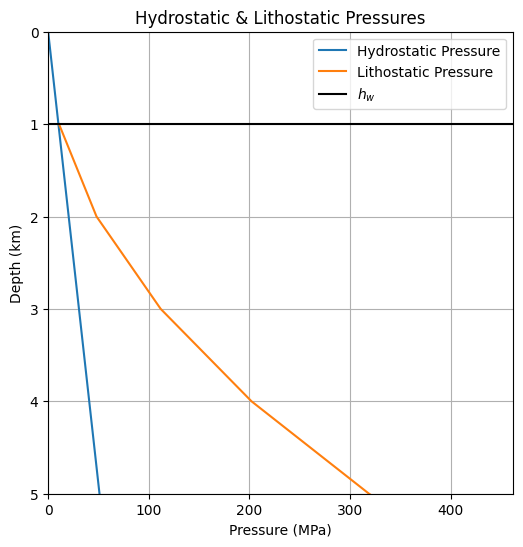

In [82]:
def hydrostatic_pressures(depths, rho_water=1040):
    """
    Calculate cumulative рнвкщыефешс pressures for each layer.

    Parameters:
    - depths: List or array of bootom depth of each layer (m)
    - rho_water: Constant value of sea water density (g/m^3)

    Returns:
    - List of cumulative pressures (MPa) for each layer
    """
    g = 9.81  # acceleration due to gravity in m/s^2
    pressures = [quad(lambda z: rho_water * g, 0, depth)[0] / 1e6 for depth in depths]  # Convert Pa to MPa
    return pressures

def lithostatic_pressures(layer_thicknesses, rock_densities, porosities,
                          water_depth=1000, sediment_surface=1000):
    """
    Calculate cumulative lithostatic pressures for each layer.

    Parameters:
    - layer_thicknesses: List or array of thicknesses of each layer (m)
    - rock_densities: List or array of densities of each rock layer (kg/m^3)
    - porosities: List or array of porosity values for each layer (fraction)
    - water_depth: Constant value of a water depth (m)

    Returns:
    - List of cumulative pressures (MPa) for each layer
    """
    g = 9.81  # acceleration due to gravity in m/s^2
    rho_sea = 1100
    pressures = []
    total_depth = 0
    total_pressure = 0
    layer_depths = np.cumsum(layer_thicknesses)

    for depth, density, porosity in zip(layer_depths, rock_densities, porosities):
        effective_density = density * (1 - porosity) + rho_sea*porosity

        pressure_increment = effective_density * g * (depth-sediment_surface)
        print(depth, depth-sediment_surface)
        water_pressure = g * rho_sea * water_depth
        total_pressure += pressure_increment
        total_pressure += water_pressure
        pressures.append((total_pressure) / 1e6)  # Convert Pa to MPa

    return pressures


def pressure(pressure_types):
    # Hydrostatic pressure
    depths = np.linspace(0, 5000, 6)  # depths in meters

    # Lithostatic pressure
    layer_thicknesses = np.array([1000, 1000, 1000, 1000, 1000, 1000])  # thickness of each layer in meters
    rock_densities = np.array([2700, 2700, 2700, 2700, 2700, 2700])  # density of each rock layer in kg/m^3
    porosities = np.array([0., 0., 0., 0., 0., 0.])  # porosity of each layer

    if 'hydrostatic' in pressure_types:
        pressures_hydrostatic = hydrostatic_pressures(depths)
        print("Hydrostatic pressures (MPa):", pressures_hydrostatic)

    if 'lithostatic' in pressure_types:
        lith_pressures = lithostatic_pressures(layer_thicknesses, rock_densities, porosities)
        print("Lithostatic pressures (MPa):", lith_pressures)
        layer_depths = np.cumsum(layer_thicknesses)
        # layer_depths = np.insert(layer_depths, 0, 0)
        # pressures_lit = np.insert(lith_pressures, 0, 0)
        # print("Lithostatic pressures (MPa):", pressures_lit)

    # Plotting
    plt.figure(figsize=(6, 6))
    ax1 = plt.subplot(1, 1, 1)

    if 'hydrostatic' in pressure_types:
        plt.plot(pressures_hydrostatic, depths / 1000, label='Hydrostatic Pressure')  # Convert depths to km
    if 'lithostatic' in pressure_types:
        plt.plot(lith_pressures, layer_depths / 1000, label='Lithostatic Pressure')  # Convert layer depths to km

    plt.plot([np.min(pressures_hydrostatic), np.max(lith_pressures)],
     [water_depth*1e-3, water_depth*1e-3], color='black', label=f'$h_w$') # Sea water level (hw)

    plt.title('Hydrostatic & Lithostatic Pressures')
    plt.ylabel('Depth (km)')
    plt.xlabel('Pressure (MPa)')
    plt.ylim(5, 0)  # Set limits after converting depths to km
    plt.xlim([np.min(pressures_hydrostatic), np.max(lith_pressures)])
    plt.legend()
    plt.grid(True)
    plt.show()

pressure(['hydrostatic', 'lithostatic'])